In [1]:
using DelimitedFiles, HDF5, FileIO
using Plots, Rsvg, LaTeXStrings
using Chemfiles, JUMD, NamedArrays
using LinearAlgebra, Statistics
home = "/home/pbarletta/labo/20/dynein/run"
rtdos = "/home/pbarletta/labo/20/dynein/rtdos_log"

"/home/pbarletta/labo/20/dynein/rtdos_log"

In [2]:
pdb = "lf3f"
# Leo modos
modes_lf3f, evals_lf3f = JUMD.readPtrajModes(joinpath(home, pdb,  "4_pca", string("4_modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_lf3f))
aa = convert(Int64, aa3 / 3)

# Leo volumen de la traj
trj_vol_acb = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "4_cavidad", "4_vol_acb_trj_het"))[:, 3]);
trj_vol_adb = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "4_cavidad", "4_vol_adb_trj_het"))[:, 3]);

# Leo volúmenes originales
vol_avg_acb = convert(Float64, readdlm(joinpath(home, pdb,  "4_cavidad", "4_vol_acb_het"))[3])
vol_avg_adb = convert(Float64, readdlm(joinpath(home, pdb,  "4_cavidad", "4_vol_adb_het"))[3])

102.543

## Volumen de la trayectoria

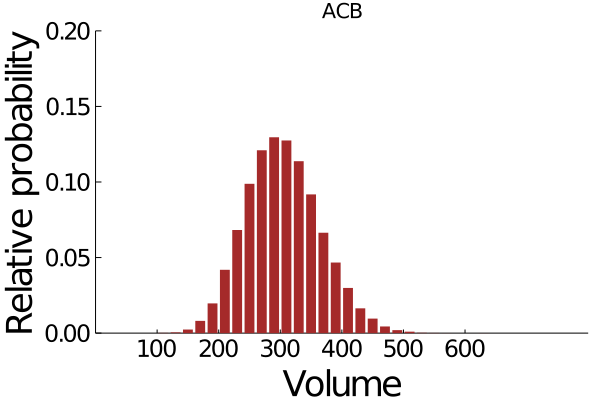

In [3]:
st = 20
bin_vol = collect(0:st:800)
wgh_vol = fill(1.0, length(trj_vol_acb))

# Histograma ponderado
Wbins_vol_acb, Whis_vol_acb = JUMD.weightedHist(trj_vol_acb, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_acb, Whis_vol_acb,
    xlims = (0, 800), ylims = (0, .2),
    xticks = 100:100:600,
    linecolor = false, fillcolor = Colors.colorant"Brown",
    grid = false, legend = false,
    guidefont = font(24, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"),
    title = "ACB", yaxis = "Relative probability", xaxis = "Volume")

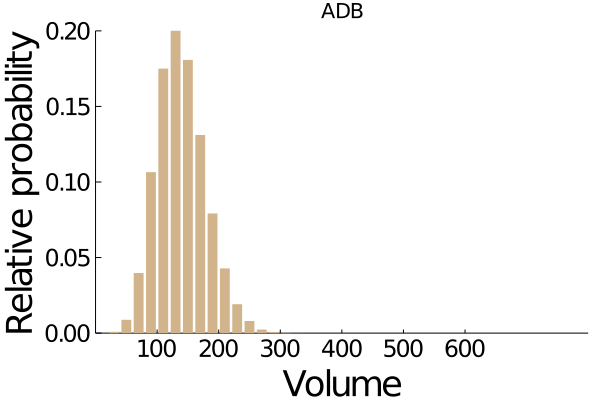

In [4]:
st = 20
bin_vol = collect(0:st:800)
wgh_vol = fill(1.0, length(trj_vol_adb))

# Histograma ponderado
Wbins_vol_adb, Whis_vol_adb = JUMD.weightedHist(trj_vol_adb, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_adb, Whis_vol_adb,
    xlims = (0, 800), ylims = (0, .2),
    xticks = 100:100:600,
    linecolor = false, fillcolor = Colors.colorant"Tan",
    grid = false, legend = false,
    guidefont = font(24, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"),
    title = "ADB", yaxis = "Relative probability", xaxis = "Volume")

In [5]:
NamedArray([ mean(trj_vol_acb) std(trj_vol_acb) std(trj_vol_acb) / mean(trj_vol_acb) ; 
     mean(trj_vol_adb) std(trj_vol_adb) std(trj_vol_adb) / mean(trj_vol_adb) ],
    (["ACB" ; "ADB"], ["μ" ; "std" ; "μ/std"]))

2×3 Named Array{Float64,2}
A ╲ B │        μ       std     μ/std
──────┼─────────────────────────────
ACB   │  304.293   60.0296  0.197276
ADB   │  139.489   39.3624  0.282189

# PCA projección
#### Obtengo vectores diferencia de la trayectoria. Esto lo hago una sola vez

In [6]:
function diff_trj_avg(in_avg_filename::AbstractString, in_trj_filename::AbstractString,
        mask::Array{Int64, 1})
    in_avg_trj = Trajectory(in_avg_filename)
    in_avg_frm = read(in_avg_trj)
    in_avg_top = Topology(in_avg_frm)
    orig_aa = convert(Int64, count_residues(in_avg_top))

    # Get indices de CA
    orig_cas_idx = Array{Int64, 1}(undef, orig_aa)
    k = 0
    for i = 0:convert(Int64, size(in_avg_top)-1)
        if Chemfiles.name(Atom(in_avg_frm, i)) == "CA"
            k+=1
            orig_cas_idx[k] = i + 1
        end
    end
    cas_idx = orig_cas_idx[mask]
    aa = length(cas_idx)
    aa_3 = aa * 3
    # Estas son las coordenadas q voy a usar p/ restar
    avg_xyz = positions(in_avg_frm)[:, cas_idx];

    # Preparo
    in_trj = Trajectory(in_trj_filename)
    nframes = convert(Int64, length(in_trj))
    close(in_trj)
    diff_pdb = Array{Float64, 2}(undef, aa_3, nframes)
    vec_nframes = convert(Array{Int64}, collect(0:nframes/10:nframes));

    # Ahora obtengo las proyecciones
    for j = 1:length(vec_nframes)-1
        in_trj = Trajectory(in_trj_filename)
        for i = vec_nframes[j]:vec_nframes[j+1]-1
            diff_pdb[:, i+1] =
                reshape(positions(read_step(in_trj, i))[:, cas_idx] .- avg_xyz, aa_3)
        end
        close(in_trj)
        println(j)
        GC.gc()
    end

    return diff_pdb
end

dif = diff_trj_avg(joinpath(home, pdb, "4_pca", string("4_avg_", pdb, ".pdb")),
    joinpath(home, pdb, "4_pca", string("4_full_avgfit_", pdb, ".nc")),
    collect(1:204))

fid = h5open(joinpath(rtdos, string("4_diff_", pdb, ".h5")), "w")
write(fid, "dif",dif)
close(fid)

1
2
3
4
5
6
7
8
9
10


#### Obtengo las proyecciónes de vectores diferencia sobre los 1eros PCA

In [7]:
dif = h5read(joinpath(rtdos, string("4_diff_", pdb, ".h5")), "dif")
norm_dif = mapslices(x -> x ./ norm(x), dif, dims = 1)
nframes = size(dif)[2]

prj_1_lf3f = Array{Float64, 1}(undef, nframes)
prj_2_lf3f = Array{Float64, 1}(undef, nframes)
prj_3_lf3f = Array{Float64, 1}(undef, nframes)

for i = 1:nframes
    prj_1_lf3f[i] = dot(norm_dif[:, i], modes_lf3f[:, 1])
    prj_2_lf3f[i] = dot(norm_dif[:, i], modes_lf3f[:, 2])
    prj_3_lf3f[i] = dot(norm_dif[:, i], modes_lf3f[:, 3])
end

# Smooth
smooth_prj_1_lf3f = [ mean(prj_1_lf3f[i:i+9]) for i = 1:10:length(prj_1_lf3f)-9 ]
smooth_prj_2_lf3f = [ mean(prj_2_lf3f[i:i+9]) for i = 1:10:length(prj_2_lf3f)-9 ]
smooth_prj_3_lf3f = [ mean(prj_3_lf3f[i:i+9]) for i = 1:10:length(prj_3_lf3f)-9 ];

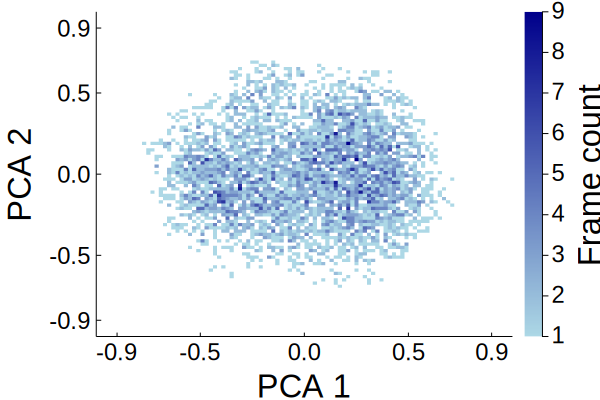

In [8]:
plt_2his = histogram2d(smooth_prj_1_lf3f, smooth_prj_2_lf3f, 
    xlims = (-1, 1), ylims = (-1, 1),
    xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
    yaxis = "PCA 2", xaxis = "PCA 1",
    colorbar_title = "Frame count",
    guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"), #clims = (0, 15),
    nbins = 120, seriescolor = :blues, grid = false)

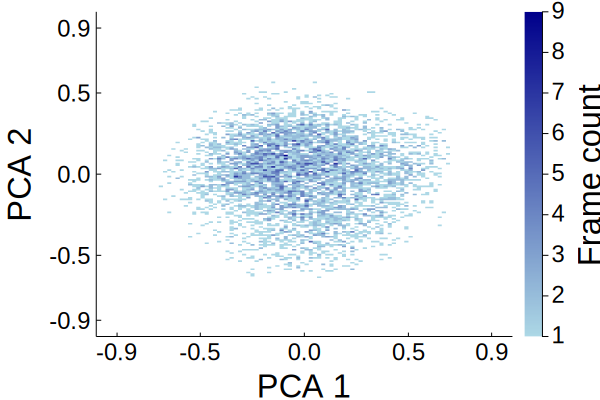

In [9]:
plt_2his = histogram2d(smooth_prj_2_lf3f, smooth_prj_3_lf3f, 
    xlims = (-1, 1), ylims = (-1, 1),
    xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
    yaxis = "PCA 2", xaxis = "PCA 1",
    colorbar_title = "Frame count",
    guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"), #clims = (0, 15),
    nbins = 120, seriescolor = :blues, grid = false)